In [68]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, Rescaling
import tensorflow.keras.layers as tfl
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from skimage import io, color, transform, util
import pandas as pd
import os
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import multilabel_confusion_matrix, classification_report, roc_auc_score

%matplotlib inline

# Classes
- endocapillary: 1
- endomes: 2
- mesangial: 3
- normal: 4

In [69]:
INPUT_SHAPE = 256

In [70]:
train = image_dataset_from_directory('train_balanced/',
                            shuffle=True,
                            batch_size=32,
                            image_size=(INPUT_SHAPE,INPUT_SHAPE),
                            validation_split=0.2,
                            subset='training',
                            seed=42)

test = image_dataset_from_directory('train_balanced/',
                            shuffle=True,
                            batch_size=32,
                            image_size=(INPUT_SHAPE,INPUT_SHAPE),
                            validation_split=0.2,
                            subset='validation',
                            seed=42)

Found 444 files belonging to 4 classes.
Using 356 files for training.
Found 444 files belonging to 4 classes.
Using 88 files for validation.


In [71]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

augmentations = tf.keras.Sequential([
        Rescaling(1./255),
        RandomFlip("horizontal_and_vertical",seed=42)
        ])

train = (train.map(lambda x, y: (augmentations(x), y), num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE))

test = test.map(lambda x, y: (x, tf.one_hot(y, 4)))
train = train.map(lambda x, y: (x, tf.one_hot(y, 4)))

In [72]:
label_dict = {0: 'endocapillary', 1: 'endomes', 2: 'mesangial', 3: 'normal'}

C:\Users\brunosm\AppData\Roaming\Python\Python39\site-packages\matplotlib\text.py:1215: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


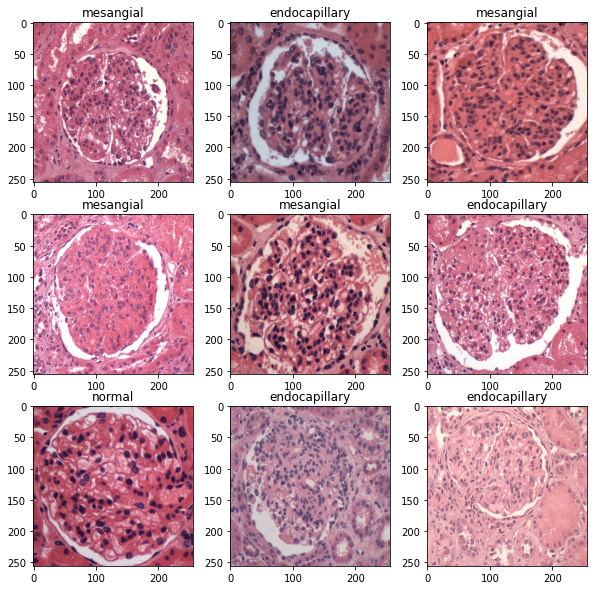

In [73]:
for imgs, labels in test.take(1):
    plt.figure(figsize=(10,10))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(imgs[i].numpy().astype('uint8'))
        plt.title(labels[i].numpy())
        plt.title(label_dict[np.argmax(labels[i].numpy(),axis=0)])

### Convnet with 4 conv + maxpoll + 1 conv + 1 avg pool + 1 dense + 1 dense + softmax

In [74]:
# Convnet with 4 conv + maxpoll + 1 conv + 1 avg pool + 1 dense + 1 dense + softmax
def convnet2(input_shape = (INPUT_SHAPE, INPUT_SHAPE, 3), num_classes = 4):
    inputs = tfl.Input(input_shape)

    model = tf.keras.Sequential()
    model.add(tfl.Conv2D(32, (3, 3), kernel_initializer= tf.keras.initializers.glorot_uniform(seed=42), input_shape=input_shape, padding='same'))
    model.add(tfl.Activation('relu'))
    model.add(tfl.MaxPool2D((2, 2)))
    model.add(tfl.Dropout(0.35,seed=42))


    model.add(tfl.Conv2D(32, (3, 3), kernel_initializer= tf.keras.initializers.glorot_uniform(seed=42), padding='same'))
    model.add(tfl.Activation('relu'))
    model.add(tfl.MaxPool2D((2, 2)))
    model.add(tfl.Dropout(0.35,seed=42))


    model.add(tfl.Conv2D(64, (3, 3), kernel_initializer= tf.keras.initializers.glorot_uniform(seed=42), padding='same'))
    model.add(tfl.Activation('relu'))
    model.add(tfl.MaxPool2D((2, 2)))
    model.add(tfl.Dropout(0.35,seed=42))

    
    model.add(tfl.Conv2D(64, (3, 3), kernel_initializer= tf.keras.initializers.glorot_uniform(seed=42), padding='same'))
    model.add(tfl.Activation('relu'))
    model.add(tfl.MaxPooling2D((2, 2)))
    model.add(tfl.Dropout(0.35,seed=42))
   
    model.add(tfl.Flatten())
    model.add(tfl.Dense(128, kernel_initializer= tf.keras.initializers.glorot_uniform(seed=42)))
    model.add(tfl.Activation('relu'))
    model.add(tfl.Dropout(0.5,seed=42))
    model.add(tfl.Dense(4))
    model.add(tfl.Activation('softmax'))

    return model

In [75]:
# best until now -> 50 epochs, default learning rate, adam optimizer, cross entropy loss without class weights, balanced dataset, 32 - 32 - 64 - 64 - drop0.5  <<< enviada
def convnet(input_shape = (INPUT_SHAPE, INPUT_SHAPE, 3), num_classes = 4):
    inputs = tfl.Input(input_shape)

    model = tf.keras.Sequential()
    model.add(tfl.Conv2D(32, (3, 3), kernel_initializer= tf.keras.initializers.glorot_uniform(seed=42), input_shape=input_shape))
    model.add(tfl.Activation('relu'))
    #model.add(tfl.BatchNormalization())
    model.add(tfl.MaxPool2D((2, 2)))

    model.add(tfl.Conv2D(32, (3, 3), kernel_initializer= tf.keras.initializers.glorot_uniform(seed=42)))
    model.add(tfl.Activation('relu'))
    #model.add(tfl.BatchNormalization())
    model.add(tfl.MaxPool2D(pool_size=(2, 2)))

    model.add(tfl.Conv2D(64, (3, 3), kernel_initializer= tf.keras.initializers.glorot_uniform(seed=42)))
    model.add(tfl.Activation('relu'))
    #model.add(tfl.BatchNormalization())
    model.add(tfl.MaxPool2D(pool_size=(2, 2)))

    model.add(tfl.Flatten())
    model.add(tfl.Dense(64, kernel_initializer= tf.keras.initializers.glorot_uniform(seed=42)))
    model.add(tfl.Activation('relu'))
    model.add(tfl.Dropout(0.5,seed=42))
    model.add(tfl.Dense(4))
    model.add(tfl.Activation('softmax'))

    return model

In [76]:
# best until now -> 50 epochs, default learning rate, adam optimizer, cross entropy loss without class weights, balanced dataset, 32 - 32 - 64 - 64 - drop0.5
def convnet3(input_shape = (INPUT_SHAPE, INPUT_SHAPE, 3), num_classes = 4):
    inputs = tfl.Input(input_shape)

    model = tf.keras.Sequential()
    model.add(tfl.Conv2D(32, (3, 3), kernel_initializer= tf.keras.initializers.glorot_uniform(seed=42), input_shape=input_shape))
    model.add(tfl.Activation('relu'))
    #model.add(tfl.BatchNormalization())
    model.add(tfl.MaxPool2D((2, 2)))

    model.add(tfl.Conv2D(32, (3, 3), kernel_initializer= tf.keras.initializers.glorot_uniform(seed=42)))
    model.add(tfl.Activation('relu'))
    #model.add(tfl.BatchNormalization())
    model.add(tfl.MaxPooling2D(pool_size=(2, 2)))

    model.add(tfl.Conv2D(64, (3, 3), kernel_initializer= tf.keras.initializers.glorot_uniform(seed=42)))
    model.add(tfl.Activation('relu'))
    #model.add(tfl.BatchNormalization())
    model.add(tfl.MaxPooling2D(pool_size=(2, 2)))

    model.add(tfl.Flatten())
    model.add(tfl.Dense(128, kernel_initializer= tf.keras.initializers.glorot_uniform(seed=42)))
    model.add(tfl.Activation('relu'))
    model.add(tfl.Dense(4))
    model.add(tfl.Activation('softmax'))

    return model

In [77]:
# Convnet with 4 conv + maxpoll + 1 conv + 1 avg pool + 1 dense + 1 dense + softmax
def convnet4(input_shape = (INPUT_SHAPE, INPUT_SHAPE, 3), num_classes = 4):
    inputs = tfl.Input(input_shape)

    model = tf.keras.Sequential()
    model.add(tfl.Conv2D(32, (3, 3), kernel_initializer= tf.keras.initializers.zeros(), input_shape=input_shape, padding='same'))
    model.add(tfl.Activation('relu'))
    model.add(tfl.MaxPool2D((2, 2)))
    model.add(tfl.Dropout(0.35,seed=42))


    model.add(tfl.Conv2D(32, (3, 3), kernel_initializer= tf.keras.initializers.zeros(), padding='same'))
    model.add(tfl.Activation('relu'))
    model.add(tfl.MaxPool2D((2, 2)))
    model.add(tfl.Dropout(0.35,seed=42))


    model.add(tfl.Conv2D(64, (3, 3), kernel_initializer= tf.keras.initializers.zeros(), padding='same'))
    model.add(tfl.Activation('relu'))
    model.add(tfl.MaxPool2D((2, 2)))
    model.add(tfl.Dropout(0.35,seed=42))

    
    model.add(tfl.Conv2D(64, (3, 3), kernel_initializer= tf.keras.initializers.zeros(), padding='same'))
    model.add(tfl.Activation('relu'))
    model.add(tfl.MaxPooling2D((2, 2)))
    model.add(tfl.Dropout(0.35,seed=42))
   
    model.add(tfl.Flatten())
    model.add(tfl.Dense(128, kernel_initializer= tf.keras.initializers.zeros()))
    model.add(tfl.Activation('relu'))
    model.add(tfl.Dropout(0.3,seed=42))
    model.add(tfl.Dense(4))
    model.add(tfl.Activation('softmax'))

    return model

In [78]:
model = convnet()
model2 = convnet2()
model3 = convnet3()
model4 = convnet4()
#print(model.summary())

In [79]:
#tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False)

#### plot dos filtros que estão sendo usados

In [80]:
""" for layer in model.layers:
    if 'conv' in layer.name:
        plt.figure(figsize=(16, 16))
        weights, bias = layer.get_weights()

        f_min, f_max = weights.min(), weights.max()
        filters = (weights - f_min) / (f_max - f_min)
        filter_cnt = 1
        print(filters.shape)
        for i in range(filters.shape[3]):
            filt = filters[:, :, :, i]
            for j in range(filters.shape[0]):
                ax = plt.subplot(filters.shape[3], filters.shape[0], filter_cnt)
                ax.set_xticks([])
                ax.set_yticks([])
                plt.imshow(filt[:, :, j], cmap='gray')
                filter_cnt += 1
        plt.show() """

" for layer in model.layers:\n    if 'conv' in layer.name:\n        plt.figure(figsize=(16, 16))\n        weights, bias = layer.get_weights()\n\n        f_min, f_max = weights.min(), weights.max()\n        filters = (weights - f_min) / (f_max - f_min)\n        filter_cnt = 1\n        print(filters.shape)\n        for i in range(filters.shape[3]):\n            filt = filters[:, :, :, i]\n            for j in range(filters.shape[0]):\n                ax = plt.subplot(filters.shape[3], filters.shape[0], filter_cnt)\n                ax.set_xticks([])\n                ax.set_yticks([])\n                plt.imshow(filt[:, :, j], cmap='gray')\n                filter_cnt += 1\n        plt.show() "

#### feature map

In [81]:
""" sucessive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = tf.keras.models.Model(inputs=model.input, outputs=sucessive_outputs)

x = image.load_img('C:/Users/brunosm/Documents/disciplinas/VISAOC/kaggle/test/2003PC0154aa.jpg', target_size=(INPUT_SHAPE,INPUT_SHAPE))
x = np.array(x)
x = x/255.0
x = x.reshape(1, INPUT_SHAPE, INPUT_SHAPE, 3)

sucessive_feature_maps = visualization_model.predict(x)

layer_names = [layer.name for layer in model.layers]
for layer_name, feature_map in zip(layer_names, sucessive_feature_maps):
    plt.figure(figsize=(16, 16))
    if len(feature_map.shape) == 4:
        n_features = feature_map.shape[-1]
        size = feature_map.shape[1]

        display_grid = np.zeros((size, size * n_features))

        for i in range(n_features):
            x = feature_map[0, :, :, i]
            x -= x.mean()
            x /= x.std()
            x *= 64
            x += 128
            x = np.clip(x, 0, 255).astype('uint8')
            display_grid[:, i * size : (i + 1) * size] = x

        scale = 20. / n_features
        plt.figure(figsize=(scale * n_features, scale))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto')
 """

" sucessive_outputs = [layer.output for layer in model.layers[1:]]\nvisualization_model = tf.keras.models.Model(inputs=model.input, outputs=sucessive_outputs)\n\nx = image.load_img('C:/Users/brunosm/Documents/disciplinas/VISAOC/kaggle/test/2003PC0154aa.jpg', target_size=(INPUT_SHAPE,INPUT_SHAPE))\nx = np.array(x)\nx = x/255.0\nx = x.reshape(1, INPUT_SHAPE, INPUT_SHAPE, 3)\n\nsucessive_feature_maps = visualization_model.predict(x)\n\nlayer_names = [layer.name for layer in model.layers]\nfor layer_name, feature_map in zip(layer_names, sucessive_feature_maps):\n    plt.figure(figsize=(16, 16))\n    if len(feature_map.shape) == 4:\n        n_features = feature_map.shape[-1]\n        size = feature_map.shape[1]\n\n        display_grid = np.zeros((size, size * n_features))\n\n        for i in range(n_features):\n            x = feature_map[0, :, :, i]\n            x -= x.mean()\n            x /= x.std()\n            x *= 64\n            x += 128\n            x = np.clip(x, 0, 255).astype('ui

In [82]:
_, labels = list(zip(*train))
classes = np.array([])
for batch in labels:
    classes = np.concatenate([classes, np.argmax(batch.numpy(), axis=-1)])

In [83]:
class_weights = compute_class_weight('balanced', np.unique(classes), classes)
class_weights = dict(enumerate(class_weights))

C:\Users\brunosm\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0. 1. 2. 3.], y=[1. 3. 3. 0. 2. 3. 3. 2. 2. 0. 3. 3. 3. 3. 0. 1. 0. 2. 3. 1. 3. 1. 0. 2.
 0. 3. 3. 2. 3. 2. 3. 2. 1. 3. 2. 1. 2. 3. 2. 2. 0. 3. 1. 1. 2. 1. 2. 2.
 1. 0. 0. 3. 2. 0. 0. 0. 3. 2. 1. 1. 3. 1. 2. 2. 0. 2. 1. 0. 1. 2. 3. 3.
 2. 2. 2. 1. 0. 1. 3. 2. 2. 3. 1. 0. 1. 0. 2. 2. 1. 0. 1. 1. 1. 1. 2. 0.
 3. 0. 0. 3. 3. 3. 1. 1. 1. 3. 3. 2. 2. 2. 2. 2. 0. 2. 1. 0. 3. 1. 3. 2.
 2. 1. 0. 2. 3. 2. 2. 1. 1. 1. 2. 2. 3. 2. 3. 3. 3. 3. 1. 1. 2. 0. 2. 3.
 0. 0. 0. 2. 3. 3. 2. 2. 1. 1. 1. 3. 3. 0. 0. 0. 2. 3. 3. 3. 2. 3. 1. 1.
 1. 3. 0. 2. 1. 2. 2. 2. 2. 1. 2. 1. 1. 3. 3. 1. 3. 2. 0. 2. 2. 2. 1. 2.
 2. 2. 1. 2. 3. 3. 3. 0. 3. 1. 1. 2. 0. 2. 2. 1. 3. 2. 3. 0. 2. 1. 1. 2.
 1. 3. 1. 1. 2. 3. 2. 1. 0. 1. 1. 2. 3. 2. 2. 2. 3. 2. 3. 3. 1. 3. 1. 3.
 2. 1. 2. 1. 3. 2. 3. 2. 0. 3. 1. 2. 2. 2. 2. 2. 2. 1. 2. 2. 1. 1. 0. 3.
 3. 1. 2. 2. 3. 3. 1. 2. 2. 1. 1. 3. 2. 0. 2. 3. 3. 2. 1.

In [84]:
model2.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001) , loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
model4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

C:\Users\brunosm\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [85]:
history = model.fit(train, epochs = 80, batch_size = 32, validation_data = test)
history2 = model2.fit(train, epochs = 80, batch_size = 32, validation_data = test, class_weight = class_weights)
history3 = model3.fit(train, epochs = 80, batch_size = 32, validation_data = test)
history4 = model4.fit(train, epochs = 80, batch_size = 32, validation_data = test, class_weight = class_weights)

Epoch 1/80


C:\Users\brunosm\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\keras\backend.py:4869: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


12/12 [==============================] - 2s 52ms/step - loss: 1.5575 - accuracy: 0.2753 - val_loss: 60.1971 - val_accuracy: 0.2727
Epoch 2/80
12/12 [==============================] - 1s 49ms/step - loss: 1.3374 - accuracy: 0.3483 - val_loss: 96.5052 - val_accuracy: 0.4091
Epoch 3/80
12/12 [==============================] - 1s 48ms/step - loss: 1.2847 - accuracy: 0.4157 - val_loss: 103.8145 - val_accuracy: 0.4205
Epoch 4/80
12/12 [==============================] - 1s 47ms/step - loss: 1.2510 - accuracy: 0.3989 - val_loss: 210.4656 - val_accuracy: 0.2727
Epoch 5/80
12/12 [==============================] - 1s 47ms/step - loss: 1.3355 - accuracy: 0.3567 - val_loss: 67.3836 - val_accuracy: 0.4432
Epoch 6/80
12/12 [==============================] - 1s 51ms/step - loss: 1.2470 - accuracy: 0.4635 - val_loss: 180.3740 - val_accuracy: 0.3636
Epoch 7/80
12/12 [==============================] - 1s 48ms/step - loss: 1.3235 - accuracy: 0.3736 - val_loss: 24.0171 - val_accuracy: 0.5000
Epoch 8/80
12/

In [86]:
model.evaluate(test)

3/3 [==============================] - 0s 12ms/step - loss: 331.4561 - accuracy: 0.4545


[331.4561462402344, 0.4545454680919647]

# Model Evaluation

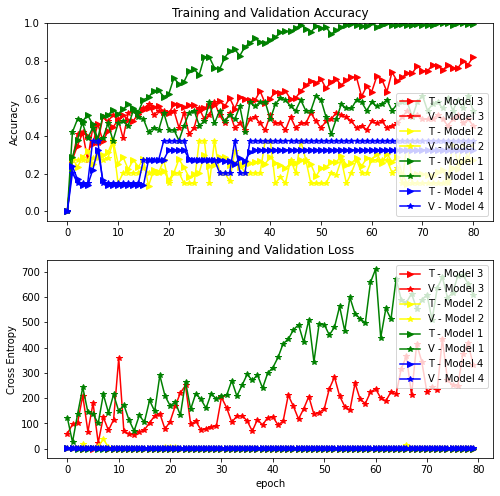

In [134]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

acc2 = [0.] + history2.history['accuracy']
val_acc2 = [0.] + history2.history['val_accuracy']

loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

acc3 = [0.] + history3.history['accuracy']
val_acc3 = [0.] + history3.history['val_accuracy']

loss3 = history3.history['loss']
val_loss3 = history3.history['val_loss']

acc4 = [0.] + history4.history['accuracy']
val_acc4 = [0.] + history4.history['val_accuracy']

loss4 = history4.history['loss']
val_loss4 = history4.history['val_loss']





plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='T - Model 3', color='red', marker = '>')
plt.plot(val_acc, label='V - Model 3', color='red', marker = '*')
plt.plot(acc2, label='T - Model 2', color='yellow', marker = '>')
plt.plot(val_acc2, label='V - Model 2', color='yellow', marker = '*')
plt.plot(acc3, label='T - Model 1', color='green', marker = '>')
plt.plot(val_acc3, label='V - Model 1', color='green', marker = '*')
plt.plot(acc4, label='T - Model 4', color='blue', marker = '>')
plt.plot(val_acc4, label='V - Model 4', color='blue', marker = '*')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='T - Model 3', color='red', marker = '>')
plt.plot(val_loss, label='V - Model 3', color='red', marker = '*')
plt.plot(loss2, label='T - Model 2', color='yellow', marker = '>')
plt.plot(val_loss2, label='V - Model 2', color='yellow', marker = '*')
plt.plot(loss3, label='T - Model 1', color='green', marker = '>')
plt.plot(val_loss3, label='V - Model 1', color='green', marker = '*')
plt.plot(loss4, label='T - Model 4', color='blue', marker = '>')
plt.plot(val_loss4, label='V - Model 4', color='blue', marker = '*')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [21]:
labels = np.array([])
preds = np.array([])
for x, y in test:
    labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])
    preds = np.concatenate([preds, np.argmax(model.predict(x), axis=-1)])

In [22]:
print(multilabel_confusion_matrix(labels, preds))

[[[74  1]
  [11  2]]

 [[58 12]
  [13  5]]

 [[42 13]
  [17 16]]

 [[46 18]
  [ 3 21]]]


In [23]:
f1_metrics = classification_report(labels, preds, output_dict=True)
print(classification_report(labels, preds))

              precision    recall  f1-score   support

         0.0       0.67      0.15      0.25        13
         1.0       0.29      0.28      0.29        18
         2.0       0.55      0.48      0.52        33
         3.0       0.54      0.88      0.67        24

    accuracy                           0.50        88
   macro avg       0.51      0.45      0.43        88
weighted avg       0.51      0.50      0.47        88



In [24]:
print("Macro f1-score")
print((f1_metrics['0.0']['f1-score']+f1_metrics['1.0']['f1-score']+f1_metrics['2.0']['f1-score']+f1_metrics['3.0']['f1-score'])/4)

Macro f1-score
0.4296274961597543


# Validation

In [88]:
from tensorflow.keras.preprocessing import image
from PIL import  Image

In [108]:
def load_images(dir, gray=False):
    labels = []
    images = []
    for file in os.listdir(dir):
        labels.append(file)
        img = image.load_img(os.path.join(dir,file), target_size=(INPUT_SHAPE,INPUT_SHAPE))
        img = np.array(img)
        img = img/255.0
        images.append(img)
    return pd.DataFrame({'Id':labels, 'Image':images})

In [109]:
test_imgs = load_images('C:/Users/brunosm/Documents/disciplinas/VISAOC/kaggle/test/')

In [110]:
test_imgs['Image'] = [x.astype('float32') for x in test_imgs['Image']]
y_hat = np.array([x.astype('float32') for x in test_imgs['Image']])

In [111]:
y_hat.shape

(232, 256, 256, 3)

In [112]:
preds = model.predict(y_hat)
preds = np.argmax(preds, axis=-1)

preds2 = model2.predict(y_hat)
preds2 = np.argmax(preds2, axis=-1)

preds3 = model3.predict(y_hat)
preds3 = np.argmax(preds3, axis=-1)

preds4 = model4.predict(y_hat)
preds4 = np.argmax(preds4, axis=-1)

In [122]:
preds3

array([3, 0, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 1, 3, 3, 1, 1, 1, 2, 3, 2, 2,
       1, 2, 2, 2, 0, 2, 1, 3, 0, 0, 2, 0, 3, 1, 0, 2, 3, 2, 2, 0, 1, 2,
       2, 1, 3, 2, 2, 3, 1, 2, 0, 0, 2, 1, 2, 2, 1, 1, 1, 2, 0, 3, 1, 1,
       0, 2, 1, 2, 0, 0, 0, 1, 2, 3, 1, 1, 1, 1, 2, 2, 0, 1, 0, 1, 1, 2,
       0, 2, 3, 1, 1, 1, 1, 2, 1, 0, 0, 1, 3, 1, 1, 2, 1, 1, 2, 0, 0, 2,
       3, 3, 0, 0, 3, 3, 3, 0, 0, 3, 3, 2, 3, 2, 3, 3, 1, 2, 2, 3, 2, 3,
       3, 0, 2, 2, 3, 3, 2, 3, 3, 3, 3, 1, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 2, 3, 1, 1, 0, 1, 1, 2, 0, 1, 0, 2, 1, 0, 2, 2, 2, 2,
       0, 1, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 0, 2, 3, 1, 2, 0, 1, 3, 0, 1,
       1, 2, 1, 0, 2, 2, 1, 2, 0, 1, 2, 2], dtype=int64)

In [123]:
test_imgs['Category'] = preds3+1

In [124]:
test_imgs['Category'].describe()

count    232.000000
mean       2.758621
std        1.061900
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        4.000000
Name: Category, dtype: float64

In [125]:
test_imgs.drop(columns=['Image']).to_csv('C:/Users/brunosm/Documents/disciplinas/VISAOC/kaggle/extra-files/model3.csv', index=False)